In [ ]:
# Based off this tutorial: https://chih-ling-hsu.github.io/2018/01/02/clustering-python#Appendix

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import vincenty
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#########################################################################################################################

In [29]:
df_csv = pd.read_csv('cleanDatasets/master_dataset2010.csv')
df = pd.DataFrame(df_csv)
df = df.drop_duplicates(subset=["full_address","business_name"], keep = "last")
print(len(df))
df.head()

680


,business_name,lic_code,street_address,business_start_date,business_end_date,Lifespan,isClosed,full_address,business_id,name,...,Q3_16_Beautiful_Scenery,Q4_16_Beautiful_Scenery,Q1_17_Beautiful_Scenery,Q2_17_Beautiful_Scenery,Q3_17_Beautiful_Scenery,Q4_17_Beautiful_Scenery,Foodie_16,Foodie_17,lic_code_cat,district_cat
0,sizzling pot king,"Restaurant 1,000 - 2,000 Sqft",139 8th st,2017-12-28,NaN,222.0,1,"139 8th st, San Francisco, CA, 94103",94408,sizzling pot king,...,44.90,38.12,43.44,30.95,35.42,38.21,71.7725,72.4775,1,62
1,new york pizza kitchen,NaN,127 eddy st,2016-03-16,2017-03-14,363.0,0,"127 eddy st, San Francisco, CA, 94102",91028,new york pizza kitchen,...,75.89,77.29,77.06,69.04,58.59,56.70,78.1975,77.4675,-1,65
2,joint venture kitchen,"Restaurant 1,000 - 2,000 Sqft",167 11th street,2017-06-26,NaN,407.0,1,"167 11th street, San Francisco, CA, 94103",92980,joint venture kitchen,...,18.74,18.07,17.89,18.40,18.42,18.29,61.0425,61.7450,1,62
3,yan yan seafood resaurant,"Restaurant Greater Than 2,000 Sqft",2241 judah st,2014-07-01,NaN,1498.0,1,"2241 judah st, San Francisco, CA, 94122",79565,yan yan seafood restaurant,...,80.00,89.47,80.00,80.00,79.96,79.99,76.9625,78.2350,2,47
4,mr bread,"Restaurant Less Than 1,000 Sqft",1018 taraval st,2018-01-02,NaN,217.0,1,"1018 taraval st, San Francisco, CA, 94116",94616,mr bread,...,39.63,48.64,55.52,52.29,35.91,46.91,77.1225,76.1700,3,51


In [30]:
# Filter
# df = df.dropna(subset=['lic_code'])
df = df[df['Opening_year'] >= 2010] # Only restaurants opened after 2010.
len(df)

680

In [31]:
X = df[['latitude', 'longitude']].values

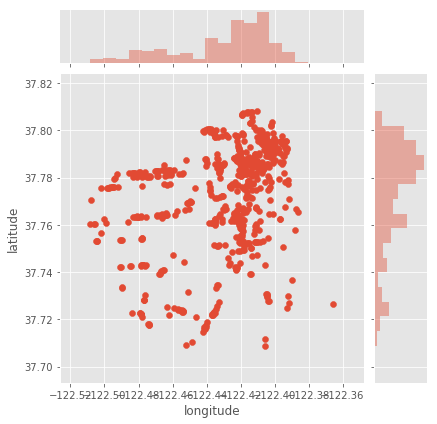

In [32]:
sns.jointplot(x="longitude", y="latitude", data=df);

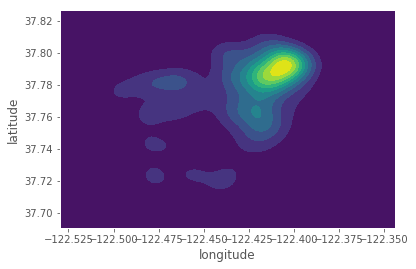

In [33]:
sns.kdeplot(df['longitude'], df['latitude'], shade=True, cmap='viridis');
# https://seaborn.pydata.org/tutorial/distributions.html

In [ ]:
########################################### K-Means ############################################################

In [34]:
# Parameters:
# - k     (Number of clusters)

Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

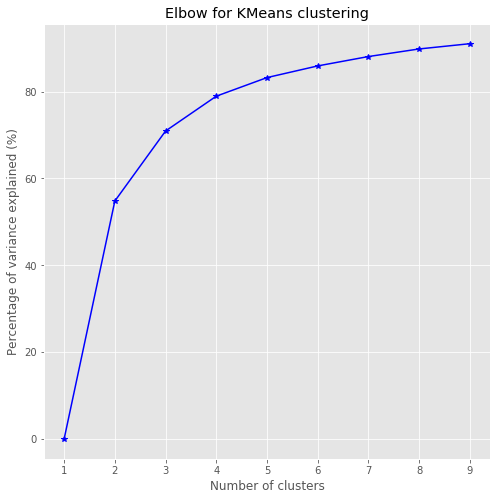

In [35]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

In [36]:
def plot_restaurant_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['latitude'])
    lon = list(stns['longitude'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['longitude']), list(df['latitude']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

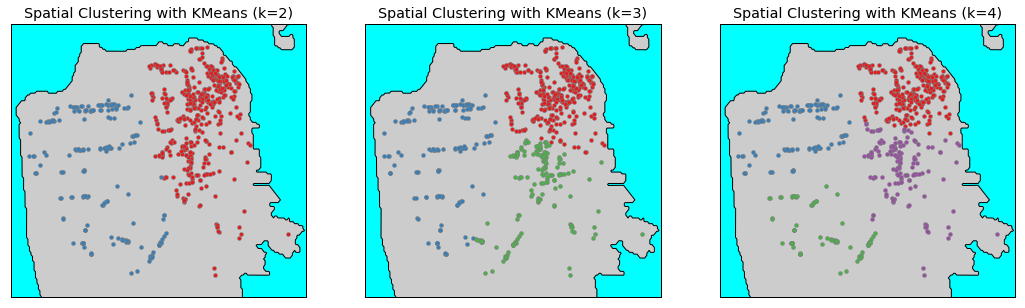

In [37]:
k = [2, 3, 4]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

for i in range(n):
    est = kmean[k[i]-1]
    df['cluster'] = est.predict(X).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_restaurant_map(ax, df)

In [38]:
#########################################################################################################################

In [59]:
# https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
df.head()

,business_name,lic_code,street_address,business_start_date,business_end_date,Lifespan,isClosed,full_address,business_id,name,...,Q4_16_Beautiful_Scenery,Q1_17_Beautiful_Scenery,Q2_17_Beautiful_Scenery,Q3_17_Beautiful_Scenery,Q4_17_Beautiful_Scenery,Foodie_16,Foodie_17,lic_code_cat,district_cat,cluster
0,sizzling pot king,"Restaurant 1,000 - 2,000 Sqft",139 8th st,2017-12-28,NaN,222.0,1,"139 8th st, San Francisco, CA, 94103",94408,sizzling pot king,...,38.12,43.44,30.95,35.42,38.21,71.7725,72.4775,1,62,0
1,new york pizza kitchen,NaN,127 eddy st,2016-03-16,2017-03-14,363.0,0,"127 eddy st, San Francisco, CA, 94102",91028,new york pizza kitchen,...,77.29,77.06,69.04,58.59,56.70,78.1975,77.4675,-1,65,0
2,joint venture kitchen,"Restaurant 1,000 - 2,000 Sqft",167 11th street,2017-06-26,NaN,407.0,1,"167 11th street, San Francisco, CA, 94103",92980,joint venture kitchen,...,18.07,17.89,18.40,18.42,18.29,61.0425,61.7450,1,62,0
3,yan yan seafood resaurant,"Restaurant Greater Than 2,000 Sqft",2241 judah st,2014-07-01,NaN,1498.0,1,"2241 judah st, San Francisco, CA, 94122",79565,yan yan seafood restaurant,...,89.47,80.00,80.00,79.96,79.99,76.9625,78.2350,2,47,1
4,mr bread,"Restaurant Less Than 1,000 Sqft",1018 taraval st,2018-01-02,NaN,217.0,1,"1018 taraval st, San Francisco, CA, 94116",94616,mr bread,...,48.64,55.52,52.29,35.91,46.91,77.1225,76.1700,3,51,3


In [64]:
w = ps.weights.Queen.from_dataframe(df)

KeyError: 'geometry'

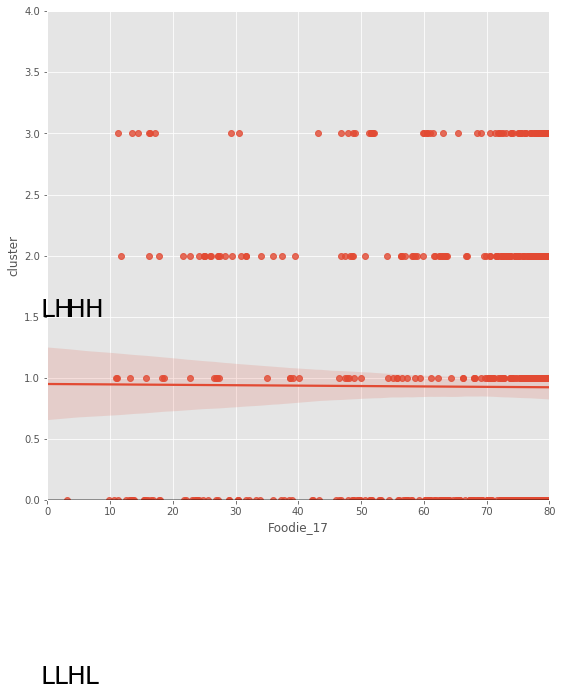

In [58]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Foodie_17', y='cluster', data=df)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(0, 80)
ax.set_ylim(0, 4)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)
# Display
plt.show()